In [ ]:
import numpy as np
import pandas as pd
import os
import glob
import mne

from sklearn.model_selection import train_test_split
from lazypredict.Supervised import LazyClassifier
from sklearn.model_selection import KFold
from sklearn.preprocessing import OneHotEncoder
from skimage.measure import block_reduce

import matplotlib.pyplot as plt

In [ ]:
# https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.model_selection import cross_val_score

In [3]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.optimizers import SGD,RMSprop,Adam
from keras.utils import np_utils
from keras import regularizers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Activation, Permute, Dropout
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import SeparableConv2D, DepthwiseConv2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import LSTM
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.layers import Input, Flatten
from tensorflow.keras.constraints import max_norm
from tensorflow.keras import backend as K

2023-05-10 19:56:08.202834: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-10 19:56:08.369696: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-05-10 19:56:09.013831: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/shivam/anaconda3/lib/:/home/shivam/anaconda3/lib/
2023-05-10 19:56:09.013917: W 

In [4]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

# Analysis Plan
## Experiments 
1. Left vs. Right
2. Inward vs. Upward vs. Downward
3. Open and close vs. Rest
4. Open vs. Close
    1. ROIs
    2. Contralteral and Ipsilateral classification
    3. Non-ROI classification

## Features
- [x] Power Spectral Density
- [x] Spectopo Plots
- [x] Time-series
- [x] ICA Activations
- [ ] ERS and ERD

## Algorithms
1. ML
    1. PSD [band-wise and entire-band]
    2. Time-series
2. CNN
    1. spectopo
3. LSTM
    1. time-series


# 1. Time-domain classification

In [56]:
dataset = pd.read_csv("/mnt/sda1/shivam/Thesis/Grasp Experiment/Data/CleanSep/cleaned_data_asr.csv")
dataset

ParserError: Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.

In [ ]:
chans, chan_count = np.unique(dataset["Channel"], return_counts=True)
chans, chan_count

In [ ]:
# Find list of channels available for every participant
good_chans = [i+1 for i in range(len(chan_count)) if chan_count[i] == 6240]
print(len(good_chans))
print(good_chans)

In [ ]:
# Subject-wise channel availability
sub_good_chans = {}
for sub in np.unique(dataset["Subject"]):
    sub_good_chans[sub] = np.unique(dataset[dataset["Subject"] == sub]["Channel"]) 
sub_good_chans

In [ ]:
def create_dataset():
    X, y_lr, y_pos, y_act = [], [], [], []
    for trial in range(1, 480):
        print("Current Trial: ", trial)
        for sub in np.unique(dataset.Subject):
            for pos in ["palmDown", "palmUp", "palmIn"]:
                for action in ["Open", "Close"]:
                    for hand in ["Left", "Right"]:
                        trial_eeg = dataset[
                            (dataset["Subject"] == sub) & 
                            (dataset["handPos"] == pos) &
                            (dataset["Trial"] == trial) &
                            (dataset["Action"] == action) &
                            (dataset["Channel"].isin(good_chans)) &
                            (dataset["Hand"] == hand) 
                        ]
                        if trial_eeg.shape[0] == 0:
                            continue
                        X.append(trial_eeg.iloc[:, :-6])
                        y_lr.append(trial_eeg.iloc[0, -5])  
                        y_pos.append(trial_eeg.iloc[0, -6])  
                        y_act.append(trial_eeg.iloc[0, -4])
        
    return np.array(X), np.array(y_lr), np.array(y_pos), np.array(y_act)
#     return np.array(y_lr), np.array(y_pos), np.array(y_act)

X, y_lr, y_pos, y_act = create_dataset()
# y_lr, y_pos, y_act = create_dataset()

In [ ]:
import pickle
os.chdir("/DATAHDD/shivam/Thesis/Data/Intermediate/TimeDomain")
with open("time-domain-X.pkl", "wb") as file:
    pickle.dump(X, file)
with open("time-domain-y_lr.pkl", "wb") as file:
    pickle.dump(y_lr, file)
with open("time-domain-y_pos.pkl", "wb") as file:
    pickle.dump(y_pos, file)
with open("time-domain-y_act.pkl", "wb") as file:
    pickle.dump(y_act, file)


In [57]:
import pickle
os.chdir("/DATAHDD/shivam/Thesis/Data/Intermediate/TimeDomain")
X = pickle.load(open("time-domain-X.pkl", "rb"))
y_lr = pickle.load(open("time-domain-y_lr.pkl", "rb"))
y_pos = pickle.load(open("time-domain-y_pos.pkl", "rb"))
y_act = pickle.load(open("time-domain-y_act.pkl", "rb"))
X.shape, y_lr.shape, y_pos.shape, y_act.shape

((6227, 48, 1100), (6227,), (6227,), (6227,))

In [58]:
X_red = block_reduce(X[:, :, :-6], block_size=(1, 1, 4), func=np.mean)
X_red = X_red.reshape((X_red.shape[0], X_red.shape[1]*X_red.shape[2]))
X_red.shape

(6227, 13152)

In [63]:
np.unique(y_pos)

array(['palmDown', 'palmIn', 'palmUp'], dtype='<U8')

# Using cross-validation and hyperparameter tuning of SVC, LGBM, and XGB

In [69]:
# Left vs. Right Classification
hand_dict = {"Left": 0, "Right": 1}
# y = np.array([hand_dict[x] for x in y_lr])

# In vs. Up vs. Down
pos_dict = {"palmDown": 0, "palmIn": 1, "palmUp": 2}
# y = np.array([pos_dict[x] for x in y_pos])

# Open vs. Close
action_dict = {"Open": 0, "Close": 1}
y = np.array([action_dict[x] for x in y_act])
X_red.shape, y.shape

((6227, 13152), (6227,))

In [70]:
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import load_iris
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Define the parameter grids for each classifier
xgb_param_grid = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.1, 0.05, 0.01]
}

lgbm_param_grid = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.1, 0.05, 0.01]
}

svc_param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf']
}

# Define the classifiers
xgb_clf = XGBClassifier()
lgbm_clf = LGBMClassifier()
svc_clf = SVC()

# Create a dictionary of classifiers and their corresponding parameter grids
classifiers = {
    'XGBoost': (xgb_clf, xgb_param_grid),
    'LightGBM': (lgbm_clf, lgbm_param_grid),
    'SVC': (svc_clf, svc_param_grid)
}

grid_scores_list = []
# Perform grid search cross-validation for each classifier
for clf_name, (clf, param_grid) in classifiers.items():
    grid_search = GridSearchCV(clf, param_grid=param_grid, cv=5, scoring='accuracy')
    grid_search.fit(X_red, y)
    
    print(f"Results for {clf_name}:")
    print("Best parameters:", grid_search.best_params_)
    print("Best score:", grid_search.best_score_)
    print()
    grid_scores_list.append(grid_search.cv_results_)


Results for XGBoost:
Best parameters: {'learning_rate': 0.05, 'n_estimators': 150}
Best score: 0.559500409342023

Results for LightGBM:
Best parameters: {'learning_rate': 0.05, 'n_estimators': 100}
Best score: 0.5631913206598465

Results for SVC:
Best parameters: {'C': 1, 'kernel': 'rbf'}
Best score: 0.5588556473083345



In [71]:
import pickle
os.chdir("/mnt/sda1/shivam/Thesis/Grasp Experiment/Data/Results/GridSearchCV")
with open("gscv-time-open-close.pkl", "wb") as f:
    pickle.dump(grid_scores_list, f)

In [ ]:
'''
Left vs Right
Results for XGBoost:
Best parameters: {'learning_rate': 0.1, 'n_estimators': 150}
Best score: 0.8960935233711733

Results for LightGBM:
Best parameters: {'learning_rate': 0.1, 'n_estimators': 150}
Best score: 0.8994675330535624

Results for SVC:
Best parameters: {'C': 1, 'kernel': 'rbf'}
Best score: 0.8972181502897625
'''

# LSTM based approach

In [12]:
y = y_act
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(y.reshape(-1, 1))
y_oh = enc.transform(y.reshape(-1, 1)).toarray()
y_oh.shape, y.shape

((6227, 2), (6227,))

In [27]:
X_train, X_eval, y_train, y_eval = train_test_split(X[:, :, :400], y_oh, test_size=0.2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
X_train.shape, X_eval.shape, X_test.shape, y_train.shape, y_eval.shape, y_test.shape

((3984, 48, 400),
 (1246, 48, 400),
 (997, 48, 400),
 (3984, 2),
 (1246, 2),
 (997, 2))

In [28]:
n_features = 48 # Channels
n_class = 2
segment_length = 400 # number of samples per trial
EPOCHS = 50
batch_size = 128
LR = 0.001
n_hidden = 128

In [29]:
model = Sequential()
model.add(LSTM(
    n_hidden, 
    input_shape=(n_features, segment_length),
#     kernel_initializer="glorot_uniform", 
#     recurrent_initializer="orthogonal",
    dropout=0.8,
    recurrent_dropout=0.8
))

model.add(Dense(2, activation="softmax"))
model.compile(loss="categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate=LR), metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=EPOCHS, batch_size=batch_size, validation_data=(X_eval, y_eval))

Epoch 1/50
32/32 [==============================] - 6s 135ms/step - loss: 0.7623 - accuracy: 0.5118 - val_loss: 0.7571 - val_accuracy: 0.4992
Epoch 2/50
32/32 [==============================] - 4s 126ms/step - loss: 0.7462 - accuracy: 0.5085 - val_loss: 0.7320 - val_accuracy: 0.5345
Epoch 3/50
32/32 [==============================] - 4s 129ms/step - loss: 0.7359 - accuracy: 0.5178 - val_loss: 0.7173 - val_accuracy: 0.5265
Epoch 4/50
32/32 [==============================] - 4s 128ms/step - loss: 0.7307 - accuracy: 0.5053 - val_loss: 0.7255 - val_accuracy: 0.5152
Epoch 5/50
32/32 [==============================] - 4s 126ms/step - loss: 0.7152 - accuracy: 0.5173 - val_loss: 0.7241 - val_accuracy: 0.4912
Epoch 6/50
32/32 [==============================] - 4s 128ms/step - loss: 0.7172 - accuracy: 0.5040 - val_loss: 0.7161 - val_accuracy: 0.5016
Epoch 7/50
32/32 [==============================] - 4s 129ms/step - loss: 0.7085 - accuracy: 0.5126 - val_loss: 0.7105 - val_accuracy: 0.5144
Epoch 

KeyboardInterrupt: 

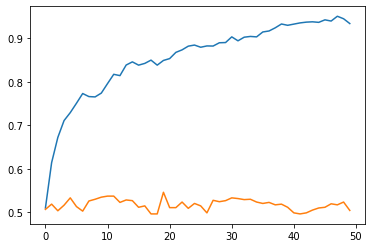

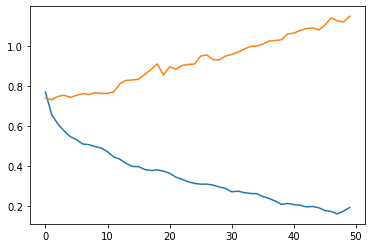

In [20]:
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.show()
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.show()

## 1. Left vs. Right

In [95]:
X_train, X_eval, y_train, y_eval = train_test_split(
    X_red.reshape((X_red.shape[0], X_red.shape[1]*X_red.shape[2])), y_lr, test_size=0.2, random_state=42
)
X_train.shape, X_eval.shape, y_train.shape, y_eval.shape

((4981, 19200), (1246, 19200), (4981,), (1246,))

In [96]:
clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
models,predictions = clf.fit(X_train, X_eval, y_train, y_eval)
models

100%|███████████████████████████████████████████| 29/29 [36:08<00:00, 74.77s/it]


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
SVC,0.89,0.89,None,0.89,137.23
LGBMClassifier,0.88,0.88,None,0.88,43.02
NuSVC,0.87,0.87,None,0.87,171.21
ExtraTreesClassifier,0.86,0.86,None,0.86,13.90
RandomForestClassifier,0.86,0.86,None,0.86,44.01
AdaBoostClassifier,0.84,0.84,None,0.84,461.71
Perceptron,0.83,0.83,None,0.83,5.34
BaggingClassifier,0.83,0.83,None,0.83,600.93
PassiveAggressiveClassifier,0.82,0.82,None,0.82,14.92


In [97]:
models.to_csv("/mnt/sda1/shivam/Thesis/Grasp Experiment/Data/Results/final/time-left-vs-right-400ms.csv")

## 2. Inward vs. upward vs. downward

In [98]:
X_train, X_eval, y_train, y_eval = train_test_split(
    X_red.reshape((X_red.shape[0], X_red.shape[1]*X_red.shape[2])), y_pos, test_size=0.2, random_state=42
)
X_train.shape, X_eval.shape, y_train.shape, y_eval.shape

((4981, 19200), (1246, 19200), (4981,), (1246,))

In [99]:
clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
models,predictions = clf.fit(X_train, X_eval, y_train, y_eval)
models

100%|████████████████████████████████████████| 29/29 [1:26:57<00:00, 179.91s/it]


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
LGBMClassifier,0.44,0.44,None,0.44,197.66
ExtraTreesClassifier,0.42,0.42,None,0.42,24.16
RandomForestClassifier,0.41,0.41,None,0.41,63.47
SVC,0.41,0.41,None,0.41,302.42
NuSVC,0.40,0.40,None,0.40,316.26
AdaBoostClassifier,0.38,0.38,None,0.38,476.71
GaussianNB,0.37,0.38,None,0.36,3.95
BaggingClassifier,0.37,0.37,None,0.37,698.39
LogisticRegression,0.36,0.36,None,0.36,10.21


In [100]:
models.to_csv("/mnt/sda1/shivam/Thesis/Grasp Experiment/Data/Results/final/time-in-vs-up-vs-down-400ms.csv")

## 3. Open vs. close

In [101]:
X_train, X_eval, y_train, y_eval = train_test_split(
    X_red.reshape((X_red.shape[0], X_red.shape[1]*X_red.shape[2])), y_act, test_size=0.2, random_state=42
)
X_train.shape, X_eval.shape, y_train.shape, y_eval.shape

((4981, 19200), (1246, 19200), (4981,), (1246,))

In [104]:
clf = LazyClassifier(verbose=0,ignore_warnings=False, custom_metric=None)
models,predictions = clf.fit(X_train, X_eval, y_train, y_eval)
models

  0%|                                                    | 0/29 [04:35<?, ?it/s]


KeyboardInterrupt: 

In [103]:
models.to_csv("/mnt/sda1/shivam/Thesis/Grasp Experiment/Data/Results/final/time-open-vs-close-400ms.csv")

## Open/Close vs. Rest

In [105]:
dataset = pd.read_csv("/mnt/sda1/shivam/Thesis/Grasp Experiment/Data/CleanSep/cleaned_data_asr_fix_v1.csv")
dataset

,0,1,2,3,4,5,6,7,8,9,...,997,998,999,Event,handPos,Hand,Action,Subject,Channel,Trial
0,-6.92,-7.04,-7.18,-7.35,-7.52,-7.69,-7.85,-7.98,-8.07,-8.12,...,-9.20,-9.17,-9.16,Fix,palmDown,Right,Open,P01,1,0
1,-7.83,-7.64,-7.46,-7.27,-7.09,-6.90,-6.71,-6.52,-6.32,-6.12,...,-0.10,-0.29,-0.48,Fix,palmDown,Right,Open,P01,2,0
2,-7.87,-7.54,-7.17,-6.76,-6.32,-5.87,-5.41,-4.96,-4.53,-4.13,...,-2.77,-2.62,-2.52,Fix,palmDown,Right,Open,P01,3,0
3,-1.14,-0.93,-0.75,-0.61,-0.51,-0.45,-0.43,-0.44,-0.48,-0.56,...,-4.28,-3.89,-3.55,Fix,palmDown,Right,Open,P01,4,0
4,-8.30,-8.16,-7.96,-7.71,-7.40,-7.05,-6.65,-6.23,-5.78,-5.31,...,8.10,7.97,7.78,Fix,palmDown,Right,Open,P01,5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
769915,8.82,8.21,7.50,6.72,5.91,5.08,4.27,3.50,2.80,2.19,...,-10.10,-10.29,-10.18,Action,palmUp,Right,Close,FP12,58,959
769916,12.37,11.62,10.73,9.72,8.63,7.49,6.32,5.17,4.05,3.01,...,-18.79,-18.98,-18.81,Action,palmUp,Right,Close,FP12,59,959
769917,6.91,6.91,6.89,6.86,6.82,6.75,6.65,6.51,6.31,6.05,...,-8.47,-7.65,-6.60,Action,palmUp,Right,Close,FP12,60,959
769918,4.53,4.61,4.67,4.71,4.75,4.78,4.82,4.87,4.93,5.00,...,-5.12,-5.36,-5.53,Action,palmUp,Right,Close,FP12,61,959


In [111]:
chans, chan_count = np.unique(dataset["Channel"], return_counts=True)
chans, chan_count

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
        35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
        52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64]),
 array([11520, 12480, 12480, 12480, 12480, 12480, 11520, 12480, 12480,
        11520, 12480, 12480, 12480, 12480, 12480, 12480, 12480, 12480,
        12480, 11520, 11520, 12480, 12480, 11520, 12480, 12480, 12480,
        12480, 12480, 12480, 12480, 12480, 12480, 12480,  9600, 12480,
        10560, 12480,  9600, 12480, 10560, 12480, 12480, 12480, 12480,
        12480, 12480, 12480, 11520, 12480, 11520, 10560, 12480, 12480,
        12480, 12480, 12480, 12480, 12480, 12480, 12480,  8640,  7680,
        11520]))

In [112]:
# Find list of channels available for every participant
good_chans = [i+1 for i in range(len(chan_count)) if chan_count[i] == 12480]
print(len(good_chans))
print(good_chans)

48
[2, 3, 4, 5, 6, 8, 9, 11, 12, 13, 14, 15, 16, 17, 18, 19, 22, 23, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 36, 38, 40, 42, 43, 44, 45, 46, 47, 48, 50, 53, 54, 55, 56, 57, 58, 59, 60, 61]


In [113]:
# Subject-wise channel availability
sub_good_chans = {}
for sub in np.unique(dataset["Subject"]):
    sub_good_chans[sub] = np.unique(dataset[dataset["Subject"] == sub]["Channel"]) 
sub_good_chans

{'FP02': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
        35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
        52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64]),
 'FP03': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
        36, 37, 38, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 53, 54,
        55, 56, 57, 58, 59, 60, 61, 62, 63, 64]),
 'FP05': array([ 1,  2,  3,  4,  5,  6,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
        19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
        36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52,
        53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64]),
 'FP06': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 22, 23, 24, 25, 26

In [122]:
def create_dataset(dataset):
    X, y_lr, y_pos, y_act, y_event = [], [], [], [], []
    n_trials = len(np.unique(dataset.Trial))
    for trial in range(n_trials):
        print("Current Trial: ", trial)
        for sub in np.unique(dataset.Subject):
            for pos in ["palmDown", "palmUp", "palmIn"]:
                for action in ["Open", "Close"]:
                    for hand in ["Left", "Right"]:
                        trial_eeg = dataset[
                            (dataset["Subject"] == sub) & 
                            (dataset["handPos"] == pos) &
                            (dataset["Trial"] == trial) &
                            (dataset["Action"] == action) &
                            (dataset["Channel"].isin(good_chans)) &
                            (dataset["Hand"] == hand) 
                        ]
                        if trial_eeg.shape[0] == 0:
                            continue
                        X.append(trial_eeg.iloc[:, :-6])
                        y_act.append(trial_eeg.iloc[0, -4])
                        y_lr.append(trial_eeg.iloc[0, -5])  
                        y_pos.append(trial_eeg.iloc[0, -6])  
                        y_event.append(trial_eeg.iloc[0, -7])
        
    return np.array(X), np.array(y_lr), np.array(y_pos), np.array(y_act), np.array(y_event)

X, y_lr, y_pos, y_act, y_event = create_dataset(dataset)

Current Trial:  0
Current Trial:  1
Current Trial:  2
Current Trial:  3
Current Trial:  4
Current Trial:  5
Current Trial:  6
Current Trial:  7
Current Trial:  8
Current Trial:  9
Current Trial:  10
Current Trial:  11
Current Trial:  12
Current Trial:  13
Current Trial:  14
Current Trial:  15
Current Trial:  16
Current Trial:  17
Current Trial:  18
Current Trial:  19
Current Trial:  20
Current Trial:  21
Current Trial:  22
Current Trial:  23
Current Trial:  24
Current Trial:  25
Current Trial:  26
Current Trial:  27
Current Trial:  28
Current Trial:  29
Current Trial:  30
Current Trial:  31
Current Trial:  32
Current Trial:  33
Current Trial:  34
Current Trial:  35
Current Trial:  36
Current Trial:  37
Current Trial:  38
Current Trial:  39
Current Trial:  40
Current Trial:  41
Current Trial:  42
Current Trial:  43
Current Trial:  44
Current Trial:  45
Current Trial:  46
Current Trial:  47
Current Trial:  48
Current Trial:  49
Current Trial:  50
Current Trial:  51
Current Trial:  52
Cur

Current Trial:  416
Current Trial:  417
Current Trial:  418
Current Trial:  419
Current Trial:  420
Current Trial:  421
Current Trial:  422
Current Trial:  423
Current Trial:  424
Current Trial:  425
Current Trial:  426
Current Trial:  427
Current Trial:  428
Current Trial:  429
Current Trial:  430
Current Trial:  431
Current Trial:  432
Current Trial:  433
Current Trial:  434
Current Trial:  435
Current Trial:  436
Current Trial:  437
Current Trial:  438
Current Trial:  439
Current Trial:  440
Current Trial:  441
Current Trial:  442
Current Trial:  443
Current Trial:  444
Current Trial:  445
Current Trial:  446
Current Trial:  447
Current Trial:  448
Current Trial:  449
Current Trial:  450
Current Trial:  451
Current Trial:  452
Current Trial:  453
Current Trial:  454
Current Trial:  455
Current Trial:  456
Current Trial:  457
Current Trial:  458
Current Trial:  459
Current Trial:  460
Current Trial:  461
Current Trial:  462
Current Trial:  463
Current Trial:  464
Current Trial:  465


Current Trial:  826
Current Trial:  827
Current Trial:  828
Current Trial:  829
Current Trial:  830
Current Trial:  831
Current Trial:  832
Current Trial:  833
Current Trial:  834
Current Trial:  835
Current Trial:  836
Current Trial:  837
Current Trial:  838
Current Trial:  839
Current Trial:  840
Current Trial:  841
Current Trial:  842
Current Trial:  843
Current Trial:  844
Current Trial:  845
Current Trial:  846
Current Trial:  847
Current Trial:  848
Current Trial:  849
Current Trial:  850
Current Trial:  851
Current Trial:  852
Current Trial:  853
Current Trial:  854
Current Trial:  855
Current Trial:  856
Current Trial:  857
Current Trial:  858
Current Trial:  859
Current Trial:  860
Current Trial:  861
Current Trial:  862
Current Trial:  863
Current Trial:  864
Current Trial:  865
Current Trial:  866
Current Trial:  867
Current Trial:  868
Current Trial:  869
Current Trial:  870
Current Trial:  871
Current Trial:  872
Current Trial:  873
Current Trial:  874
Current Trial:  875


In [139]:
X.shape

(12480, 48, 1001)

In [140]:
X_red = X[:, :, :400]
X_red.shape

(12480, 48, 400)

In [141]:
X_red.reshape((X_red.shape[0], X_red.shape[1]*X_red.shape[2])).shape

(12480, 19200)

In [143]:
len(y_event)

12480

In [144]:
X_train, X_eval, y_train, y_eval = train_test_split(
    X_red.reshape((X_red.shape[0], X_red.shape[1]*X_red.shape[2])), y_event, test_size=0.2, random_state=42
)
X_train.shape, X_eval.shape, y_train.shape, y_eval.shape

((9984, 19200), (2496, 19200), (9984,), (2496,))

In [138]:
X_eval

array([[-4.92295503616333, -4.274316787719727, -3.530621290206909, ...,
        -7.51123046875, -7.144469738006592, -6.726459980010986],
       [-3.99238920211792, -4.573351860046387, -5.19865083694458, ...,
        3.0889878273010254, 2.508065938949585, 1.9449099302291868],
       [-1.3690567016601562, -1.2272512912750242, -1.1418002843856812,
        ..., -22.24218368530273, -21.508632659912102, -20.72554016113281],
       ...,
       [-2.7587580680847164, -2.7292356491088867, -2.6308388710021973,
        ..., -3.3942432403564453, -3.685460805892944,
        -3.9943373203277583],
       [-18.59305763244629, -18.24982643127441, -17.805282592773438, ...,
        -1.7376010417938232, -2.151963472366333, -2.5701889991760254],
       [-2.782504796981811, -3.28445816040039, -3.9294309616088863, ...,
        4.226086616516113, 3.826579332351685, 3.411402463912964]],
      dtype=object)

In [145]:
clf = LazyClassifier(verbose=0,ignore_warnings=False, custom_metric=None)
models, predictions = clf.fit(X_train, X_eval, y_train, y_eval)
models

  3%|█▎                                     | 1/29 [41:12<19:13:54, 2472.68s/it]

AdaBoostClassifier model failed to execute
Found unknown categories [0.2525259852409363, -0.8598867654800415, 1.292681336402893, 3.183302402496338, -0.8613868355751038, 5.480263710021973, 5.754245281219482, 7.645411014556885, 2.5729074478149414, 9.05689811706543, 2.214402437210083, 11.633194923400875, 12.08674144744873, 10.165040016174316, 2.036757230758667, 6.0154571533203125, 16.53035545349121, 17.29422378540039, 17.365732192993164, 10.148972511291504, 2.824585437774658, 4.178518295288086, 4.077199459075928, 21.03557777404785, 4.676352500915527, 4.1976189613342285, 5.023715019226074, 5.073303699493408, 5.22401237487793, 25.74452400207519, 4.152841567993164, -0.5547786951065063, 6.72511100769043, 32.0978889465332, 32.04684066772461, 6.314841270446777, 7.587088108062744, 7.873989582061768, 6.133274078369141, 7.187895774841309, 1.6785540580749512, 8.332972526550293, 8.735750198364258, 8.033559799194336, 7.766026496887207, 7.471929550170898, 9.634332656860352, 9.221650123596191, 9.134626

  7%|██▌                                  | 2/29 [1:28:28<20:08:44, 2686.10s/it]

BaggingClassifier model failed to execute
Found unknown categories [0.2525259852409363, -0.8598867654800415, 1.292681336402893, 3.183302402496338, -0.8613868355751038, 5.480263710021973, 5.754245281219482, 7.645411014556885, 2.5729074478149414, 9.05689811706543, 2.214402437210083, 11.633194923400875, 12.08674144744873, 10.165040016174316, 2.036757230758667, 6.0154571533203125, 16.53035545349121, 17.29422378540039, 17.365732192993164, 10.148972511291504, 2.824585437774658, 4.178518295288086, 4.077199459075928, 21.03557777404785, 4.676352500915527, 4.1976189613342285, 5.023715019226074, 5.073303699493408, 5.22401237487793, 25.74452400207519, 4.152841567993164, -0.5547786951065063, 6.72511100769043, 32.0978889465332, 32.04684066772461, 6.314841270446777, 7.587088108062744, 7.873989582061768, 6.133274078369141, 7.187895774841309, 1.6785540580749512, 8.332972526550293, 8.735750198364258, 8.033559799194336, 7.766026496887207, 7.471929550170898, 9.634332656860352, 9.221650123596191, 9.1346263

 10%|███▊                                 | 3/29 [1:48:44<14:33:05, 2014.82s/it]

BernoulliNB model failed to execute
Found unknown categories [0.2525259852409363, -0.8598867654800415, 1.292681336402893, 3.183302402496338, -0.8613868355751038, 5.480263710021973, 5.754245281219482, 7.645411014556885, 2.5729074478149414, 9.05689811706543, 2.214402437210083, 11.633194923400875, 12.08674144744873, 10.165040016174316, 2.036757230758667, 6.0154571533203125, 16.53035545349121, 17.29422378540039, 17.365732192993164, 10.148972511291504, 2.824585437774658, 4.178518295288086, 4.077199459075928, 21.03557777404785, 4.676352500915527, 4.1976189613342285, 5.023715019226074, 5.073303699493408, 5.22401237487793, 25.74452400207519, 4.152841567993164, -0.5547786951065063, 6.72511100769043, 32.0978889465332, 32.04684066772461, 6.314841270446777, 7.587088108062744, 7.873989582061768, 6.133274078369141, 7.187895774841309, 1.6785540580749512, 8.332972526550293, 8.735750198364258, 8.033559799194336, 7.766026496887207, 7.471929550170898, 9.634332656860352, 9.221650123596191, 9.1346263885498

CalibratedClassifierCV model failed to execute
Found unknown categories [0.2525259852409363, -0.8598867654800415, 1.292681336402893, 3.183302402496338, -0.8613868355751038, 5.480263710021973, 5.754245281219482, 7.645411014556885, 2.5729074478149414, 9.05689811706543, 2.214402437210083, 11.633194923400875, 12.08674144744873, 10.165040016174316, 2.036757230758667, 6.0154571533203125, 16.53035545349121, 17.29422378540039, 17.365732192993164, 10.148972511291504, 2.824585437774658, 4.178518295288086, 4.077199459075928, 21.03557777404785, 4.676352500915527, 4.1976189613342285, 5.023715019226074, 5.073303699493408, 5.22401237487793, 25.74452400207519, 4.152841567993164, -0.5547786951065063, 6.72511100769043, 32.0978889465332, 32.04684066772461, 6.314841270446777, 7.587088108062744, 7.873989582061768, 6.133274078369141, 7.187895774841309, 1.6785540580749512, 8.332972526550293, 8.735750198364258, 8.033559799194336, 7.766026496887207, 7.471929550170898, 9.634332656860352, 9.221650123596191, 9.13

 14%|█████                                | 4/29 [2:35:51<16:13:10, 2335.61s/it]

CategoricalNB model failed to execute
Found unknown categories [0.2525259852409363, -0.8598867654800415, 1.292681336402893, 3.183302402496338, -0.8613868355751038, 5.480263710021973, 5.754245281219482, 7.645411014556885, 2.5729074478149414, 9.05689811706543, 2.214402437210083, 11.633194923400875, 12.08674144744873, 10.165040016174316, 2.036757230758667, 6.0154571533203125, 16.53035545349121, 17.29422378540039, 17.365732192993164, 10.148972511291504, 2.824585437774658, 4.178518295288086, 4.077199459075928, 21.03557777404785, 4.676352500915527, 4.1976189613342285, 5.023715019226074, 5.073303699493408, 5.22401237487793, 25.74452400207519, 4.152841567993164, -0.5547786951065063, 6.72511100769043, 32.0978889465332, 32.04684066772461, 6.314841270446777, 7.587088108062744, 7.873989582061768, 6.133274078369141, 7.187895774841309, 1.6785540580749512, 8.332972526550293, 8.735750198364258, 8.033559799194336, 7.766026496887207, 7.471929550170898, 9.634332656860352, 9.221650123596191, 9.13462638854

 21%|███████▋                             | 6/29 [3:21:40<11:26:28, 1790.80s/it]

DecisionTreeClassifier model failed to execute
Found unknown categories [0.2525259852409363, -0.8598867654800415, 1.292681336402893, 3.183302402496338, -0.8613868355751038, 5.480263710021973, 5.754245281219482, 7.645411014556885, 2.5729074478149414, 9.05689811706543, 2.214402437210083, 11.633194923400875, 12.08674144744873, 10.165040016174316, 2.036757230758667, 6.0154571533203125, 16.53035545349121, 17.29422378540039, 17.365732192993164, 10.148972511291504, 2.824585437774658, 4.178518295288086, 4.077199459075928, 21.03557777404785, 4.676352500915527, 4.1976189613342285, 5.023715019226074, 5.073303699493408, 5.22401237487793, 25.74452400207519, 4.152841567993164, -0.5547786951065063, 6.72511100769043, 32.0978889465332, 32.04684066772461, 6.314841270446777, 7.587088108062744, 7.873989582061768, 6.133274078369141, 7.187895774841309, 1.6785540580749512, 8.332972526550293, 8.735750198364258, 8.033559799194336, 7.766026496887207, 7.471929550170898, 9.634332656860352, 9.221650123596191, 9.13

 24%|█████████▏                            | 7/29 [3:42:08<9:49:13, 1606.96s/it]

DummyClassifier model failed to execute
Found unknown categories [0.2525259852409363, -0.8598867654800415, 1.292681336402893, 3.183302402496338, -0.8613868355751038, 5.480263710021973, 5.754245281219482, 7.645411014556885, 2.5729074478149414, 9.05689811706543, 2.214402437210083, 11.633194923400875, 12.08674144744873, 10.165040016174316, 2.036757230758667, 6.0154571533203125, 16.53035545349121, 17.29422378540039, 17.365732192993164, 10.148972511291504, 2.824585437774658, 4.178518295288086, 4.077199459075928, 21.03557777404785, 4.676352500915527, 4.1976189613342285, 5.023715019226074, 5.073303699493408, 5.22401237487793, 25.74452400207519, 4.152841567993164, -0.5547786951065063, 6.72511100769043, 32.0978889465332, 32.04684066772461, 6.314841270446777, 7.587088108062744, 7.873989582061768, 6.133274078369141, 7.187895774841309, 1.6785540580749512, 8.332972526550293, 8.735750198364258, 8.033559799194336, 7.766026496887207, 7.471929550170898, 9.634332656860352, 9.221650123596191, 9.134626388

 28%|██████████▍                           | 8/29 [4:02:36<8:40:14, 1486.39s/it]

ExtraTreeClassifier model failed to execute
Found unknown categories [0.2525259852409363, -0.8598867654800415, 1.292681336402893, 3.183302402496338, -0.8613868355751038, 5.480263710021973, 5.754245281219482, 7.645411014556885, 2.5729074478149414, 9.05689811706543, 2.214402437210083, 11.633194923400875, 12.08674144744873, 10.165040016174316, 2.036757230758667, 6.0154571533203125, 16.53035545349121, 17.29422378540039, 17.365732192993164, 10.148972511291504, 2.824585437774658, 4.178518295288086, 4.077199459075928, 21.03557777404785, 4.676352500915527, 4.1976189613342285, 5.023715019226074, 5.073303699493408, 5.22401237487793, 25.74452400207519, 4.152841567993164, -0.5547786951065063, 6.72511100769043, 32.0978889465332, 32.04684066772461, 6.314841270446777, 7.587088108062744, 7.873989582061768, 6.133274078369141, 7.187895774841309, 1.6785540580749512, 8.332972526550293, 8.735750198364258, 8.033559799194336, 7.766026496887207, 7.471929550170898, 9.634332656860352, 9.221650123596191, 9.13462

 31%|███████████▊                          | 9/29 [4:23:42<7:52:29, 1417.50s/it]

ExtraTreesClassifier model failed to execute
Found unknown categories [0.2525259852409363, -0.8598867654800415, 1.292681336402893, 3.183302402496338, -0.8613868355751038, 5.480263710021973, 5.754245281219482, 7.645411014556885, 2.5729074478149414, 9.05689811706543, 2.214402437210083, 11.633194923400875, 12.08674144744873, 10.165040016174316, 2.036757230758667, 6.0154571533203125, 16.53035545349121, 17.29422378540039, 17.365732192993164, 10.148972511291504, 2.824585437774658, 4.178518295288086, 4.077199459075928, 21.03557777404785, 4.676352500915527, 4.1976189613342285, 5.023715019226074, 5.073303699493408, 5.22401237487793, 25.74452400207519, 4.152841567993164, -0.5547786951065063, 6.72511100769043, 32.0978889465332, 32.04684066772461, 6.314841270446777, 7.587088108062744, 7.873989582061768, 6.133274078369141, 7.187895774841309, 1.6785540580749512, 8.332972526550293, 8.735750198364258, 8.033559799194336, 7.766026496887207, 7.471929550170898, 9.634332656860352, 9.221650123596191, 9.1346

 34%|████████████▊                        | 10/29 [4:43:55<7:08:49, 1354.19s/it]

GaussianNB model failed to execute
Found unknown categories [0.2525259852409363, -0.8598867654800415, 1.292681336402893, 3.183302402496338, -0.8613868355751038, 5.480263710021973, 5.754245281219482, 7.645411014556885, 2.5729074478149414, 9.05689811706543, 2.214402437210083, 11.633194923400875, 12.08674144744873, 10.165040016174316, 2.036757230758667, 6.0154571533203125, 16.53035545349121, 17.29422378540039, 17.365732192993164, 10.148972511291504, 2.824585437774658, 4.178518295288086, 4.077199459075928, 21.03557777404785, 4.676352500915527, 4.1976189613342285, 5.023715019226074, 5.073303699493408, 5.22401237487793, 25.74452400207519, 4.152841567993164, -0.5547786951065063, 6.72511100769043, 32.0978889465332, 32.04684066772461, 6.314841270446777, 7.587088108062744, 7.873989582061768, 6.133274078369141, 7.187895774841309, 1.6785540580749512, 8.332972526550293, 8.735750198364258, 8.033559799194336, 7.766026496887207, 7.471929550170898, 9.634332656860352, 9.221650123596191, 9.13462638854980

 38%|██████████████                       | 11/29 [5:04:45<6:36:42, 1322.36s/it]

KNeighborsClassifier model failed to execute
Found unknown categories [0.2525259852409363, -0.8598867654800415, 1.292681336402893, 3.183302402496338, -0.8613868355751038, 5.480263710021973, 5.754245281219482, 7.645411014556885, 2.5729074478149414, 9.05689811706543, 2.214402437210083, 11.633194923400875, 12.08674144744873, 10.165040016174316, 2.036757230758667, 6.0154571533203125, 16.53035545349121, 17.29422378540039, 17.365732192993164, 10.148972511291504, 2.824585437774658, 4.178518295288086, 4.077199459075928, 21.03557777404785, 4.676352500915527, 4.1976189613342285, 5.023715019226074, 5.073303699493408, 5.22401237487793, 25.74452400207519, 4.152841567993164, -0.5547786951065063, 6.72511100769043, 32.0978889465332, 32.04684066772461, 6.314841270446777, 7.587088108062744, 7.873989582061768, 6.133274078369141, 7.187895774841309, 1.6785540580749512, 8.332972526550293, 8.735750198364258, 8.033559799194336, 7.766026496887207, 7.471929550170898, 9.634332656860352, 9.221650123596191, 9.1346

 41%|███████████████▎                     | 12/29 [5:25:13<6:06:32, 1293.65s/it]

LabelPropagation model failed to execute
shape mismatch: objects cannot be broadcast to a single shape


 45%|████████████████▌                    | 13/29 [5:45:36<5:39:15, 1272.20s/it]

LabelSpreading model failed to execute
shape mismatch: objects cannot be broadcast to a single shape


 48%|█████████████████▊                   | 14/29 [6:12:08<5:42:13, 1368.88s/it]

LinearDiscriminantAnalysis model failed to execute
Found unknown categories [0.2525259852409363, -0.8598867654800415, 1.292681336402893, 3.183302402496338, -0.8613868355751038, 5.480263710021973, 5.754245281219482, 7.645411014556885, 2.5729074478149414, 9.05689811706543, 2.214402437210083, 11.633194923400875, 12.08674144744873, 10.165040016174316, 2.036757230758667, 6.0154571533203125, 16.53035545349121, 17.29422378540039, 17.365732192993164, 10.148972511291504, 2.824585437774658, 4.178518295288086, 4.077199459075928, 21.03557777404785, 4.676352500915527, 4.1976189613342285, 5.023715019226074, 5.073303699493408, 5.22401237487793, 25.74452400207519, 4.152841567993164, -0.5547786951065063, 6.72511100769043, 32.0978889465332, 32.04684066772461, 6.314841270446777, 7.587088108062744, 7.873989582061768, 6.133274078369141, 7.187895774841309, 1.6785540580749512, 8.332972526550293, 8.735750198364258, 8.033559799194336, 7.766026496887207, 7.471929550170898, 9.634332656860352, 9.221650123596191, 

 52%|███████████████████▏                 | 15/29 [6:38:45<5:35:25, 1437.57s/it]

LinearSVC model failed to execute
Found unknown categories [0.2525259852409363, -0.8598867654800415, 1.292681336402893, 3.183302402496338, -0.8613868355751038, 5.480263710021973, 5.754245281219482, 7.645411014556885, 2.5729074478149414, 9.05689811706543, 2.214402437210083, 11.633194923400875, 12.08674144744873, 10.165040016174316, 2.036757230758667, 6.0154571533203125, 16.53035545349121, 17.29422378540039, 17.365732192993164, 10.148972511291504, 2.824585437774658, 4.178518295288086, 4.077199459075928, 21.03557777404785, 4.676352500915527, 4.1976189613342285, 5.023715019226074, 5.073303699493408, 5.22401237487793, 25.74452400207519, 4.152841567993164, -0.5547786951065063, 6.72511100769043, 32.0978889465332, 32.04684066772461, 6.314841270446777, 7.587088108062744, 7.873989582061768, 6.133274078369141, 7.187895774841309, 1.6785540580749512, 8.332972526550293, 8.735750198364258, 8.033559799194336, 7.766026496887207, 7.471929550170898, 9.634332656860352, 9.221650123596191, 9.134626388549805

 55%|████████████████████▍                | 16/29 [6:58:40<4:55:41, 1364.77s/it]

LogisticRegression model failed to execute
Found unknown categories [0.2525259852409363, -0.8598867654800415, 1.292681336402893, 3.183302402496338, -0.8613868355751038, 5.480263710021973, 5.754245281219482, 7.645411014556885, 2.5729074478149414, 9.05689811706543, 2.214402437210083, 11.633194923400875, 12.08674144744873, 10.165040016174316, 2.036757230758667, 6.0154571533203125, 16.53035545349121, 17.29422378540039, 17.365732192993164, 10.148972511291504, 2.824585437774658, 4.178518295288086, 4.077199459075928, 21.03557777404785, 4.676352500915527, 4.1976189613342285, 5.023715019226074, 5.073303699493408, 5.22401237487793, 25.74452400207519, 4.152841567993164, -0.5547786951065063, 6.72511100769043, 32.0978889465332, 32.04684066772461, 6.314841270446777, 7.587088108062744, 7.873989582061768, 6.133274078369141, 7.187895774841309, 1.6785540580749512, 8.332972526550293, 8.735750198364258, 8.033559799194336, 7.766026496887207, 7.471929550170898, 9.634332656860352, 9.221650123596191, 9.134626

 59%|█████████████████████▋               | 17/29 [7:18:27<4:22:14, 1311.18s/it]

NearestCentroid model failed to execute
Found unknown categories [0.2525259852409363, -0.8598867654800415, 1.292681336402893, 3.183302402496338, -0.8613868355751038, 5.480263710021973, 5.754245281219482, 7.645411014556885, 2.5729074478149414, 9.05689811706543, 2.214402437210083, 11.633194923400875, 12.08674144744873, 10.165040016174316, 2.036757230758667, 6.0154571533203125, 16.53035545349121, 17.29422378540039, 17.365732192993164, 10.148972511291504, 2.824585437774658, 4.178518295288086, 4.077199459075928, 21.03557777404785, 4.676352500915527, 4.1976189613342285, 5.023715019226074, 5.073303699493408, 5.22401237487793, 25.74452400207519, 4.152841567993164, -0.5547786951065063, 6.72511100769043, 32.0978889465332, 32.04684066772461, 6.314841270446777, 7.587088108062744, 7.873989582061768, 6.133274078369141, 7.187895774841309, 1.6785540580749512, 8.332972526550293, 8.735750198364258, 8.033559799194336, 7.766026496887207, 7.471929550170898, 9.634332656860352, 9.221650123596191, 9.134626388

 62%|██████████████████████▉              | 18/29 [7:47:06<4:22:51, 1433.79s/it]

NuSVC model failed to execute
Found unknown categories [0.2525259852409363, -0.8598867654800415, 1.292681336402893, 3.183302402496338, -0.8613868355751038, 5.480263710021973, 5.754245281219482, 7.645411014556885, 2.5729074478149414, 9.05689811706543, 2.214402437210083, 11.633194923400875, 12.08674144744873, 10.165040016174316, 2.036757230758667, 6.0154571533203125, 16.53035545349121, 17.29422378540039, 17.365732192993164, 10.148972511291504, 2.824585437774658, 4.178518295288086, 4.077199459075928, 21.03557777404785, 4.676352500915527, 4.1976189613342285, 5.023715019226074, 5.073303699493408, 5.22401237487793, 25.74452400207519, 4.152841567993164, -0.5547786951065063, 6.72511100769043, 32.0978889465332, 32.04684066772461, 6.314841270446777, 7.587088108062744, 7.873989582061768, 6.133274078369141, 7.187895774841309, 1.6785540580749512, 8.332972526550293, 8.735750198364258, 8.033559799194336, 7.766026496887207, 7.471929550170898, 9.634332656860352, 9.221650123596191, 9.134626388549805, 49

 66%|████████████████████████▏            | 19/29 [8:06:36<3:45:45, 1354.55s/it]

PassiveAggressiveClassifier model failed to execute
Found unknown categories [0.2525259852409363, -0.8598867654800415, 1.292681336402893, 3.183302402496338, -0.8613868355751038, 5.480263710021973, 5.754245281219482, 7.645411014556885, 2.5729074478149414, 9.05689811706543, 2.214402437210083, 11.633194923400875, 12.08674144744873, 10.165040016174316, 2.036757230758667, 6.0154571533203125, 16.53035545349121, 17.29422378540039, 17.365732192993164, 10.148972511291504, 2.824585437774658, 4.178518295288086, 4.077199459075928, 21.03557777404785, 4.676352500915527, 4.1976189613342285, 5.023715019226074, 5.073303699493408, 5.22401237487793, 25.74452400207519, 4.152841567993164, -0.5547786951065063, 6.72511100769043, 32.0978889465332, 32.04684066772461, 6.314841270446777, 7.587088108062744, 7.873989582061768, 6.133274078369141, 7.187895774841309, 1.6785540580749512, 8.332972526550293, 8.735750198364258, 8.033559799194336, 7.766026496887207, 7.471929550170898, 9.634332656860352, 9.221650123596191,

 69%|█████████████████████████▌           | 20/29 [8:26:09<3:14:59, 1299.91s/it]

Perceptron model failed to execute
Found unknown categories [0.2525259852409363, -0.8598867654800415, 1.292681336402893, 3.183302402496338, -0.8613868355751038, 5.480263710021973, 5.754245281219482, 7.645411014556885, 2.5729074478149414, 9.05689811706543, 2.214402437210083, 11.633194923400875, 12.08674144744873, 10.165040016174316, 2.036757230758667, 6.0154571533203125, 16.53035545349121, 17.29422378540039, 17.365732192993164, 10.148972511291504, 2.824585437774658, 4.178518295288086, 4.077199459075928, 21.03557777404785, 4.676352500915527, 4.1976189613342285, 5.023715019226074, 5.073303699493408, 5.22401237487793, 25.74452400207519, 4.152841567993164, -0.5547786951065063, 6.72511100769043, 32.0978889465332, 32.04684066772461, 6.314841270446777, 7.587088108062744, 7.873989582061768, 6.133274078369141, 7.187895774841309, 1.6785540580749512, 8.332972526550293, 8.735750198364258, 8.033559799194336, 7.766026496887207, 7.471929550170898, 9.634332656860352, 9.221650123596191, 9.13462638854980

 72%|██████████████████████████▊          | 21/29 [8:49:21<2:57:00, 1327.58s/it]

QuadraticDiscriminantAnalysis model failed to execute
Found unknown categories [0.2525259852409363, -0.8598867654800415, 1.292681336402893, 3.183302402496338, -0.8613868355751038, 5.480263710021973, 5.754245281219482, 7.645411014556885, 2.5729074478149414, 9.05689811706543, 2.214402437210083, 11.633194923400875, 12.08674144744873, 10.165040016174316, 2.036757230758667, 6.0154571533203125, 16.53035545349121, 17.29422378540039, 17.365732192993164, 10.148972511291504, 2.824585437774658, 4.178518295288086, 4.077199459075928, 21.03557777404785, 4.676352500915527, 4.1976189613342285, 5.023715019226074, 5.073303699493408, 5.22401237487793, 25.74452400207519, 4.152841567993164, -0.5547786951065063, 6.72511100769043, 32.0978889465332, 32.04684066772461, 6.314841270446777, 7.587088108062744, 7.873989582061768, 6.133274078369141, 7.187895774841309, 1.6785540580749512, 8.332972526550293, 8.735750198364258, 8.033559799194336, 7.766026496887207, 7.471929550170898, 9.634332656860352, 9.22165012359619

 76%|████████████████████████████         | 22/29 [9:10:41<2:33:12, 1313.26s/it]

RandomForestClassifier model failed to execute
Found unknown categories [0.2525259852409363, -0.8598867654800415, 1.292681336402893, 3.183302402496338, -0.8613868355751038, 5.480263710021973, 5.754245281219482, 7.645411014556885, 2.5729074478149414, 9.05689811706543, 2.214402437210083, 11.633194923400875, 12.08674144744873, 10.165040016174316, 2.036757230758667, 6.0154571533203125, 16.53035545349121, 17.29422378540039, 17.365732192993164, 10.148972511291504, 2.824585437774658, 4.178518295288086, 4.077199459075928, 21.03557777404785, 4.676352500915527, 4.1976189613342285, 5.023715019226074, 5.073303699493408, 5.22401237487793, 25.74452400207519, 4.152841567993164, -0.5547786951065063, 6.72511100769043, 32.0978889465332, 32.04684066772461, 6.314841270446777, 7.587088108062744, 7.873989582061768, 6.133274078369141, 7.187895774841309, 1.6785540580749512, 8.332972526550293, 8.735750198364258, 8.033559799194336, 7.766026496887207, 7.471929550170898, 9.634332656860352, 9.221650123596191, 9.13

 79%|█████████████████████████████▎       | 23/29 [9:30:06<2:06:52, 1268.71s/it]

RidgeClassifier model failed to execute
Found unknown categories [0.2525259852409363, -0.8598867654800415, 1.292681336402893, 3.183302402496338, -0.8613868355751038, 5.480263710021973, 5.754245281219482, 7.645411014556885, 2.5729074478149414, 9.05689811706543, 2.214402437210083, 11.633194923400875, 12.08674144744873, 10.165040016174316, 2.036757230758667, 6.0154571533203125, 16.53035545349121, 17.29422378540039, 17.365732192993164, 10.148972511291504, 2.824585437774658, 4.178518295288086, 4.077199459075928, 21.03557777404785, 4.676352500915527, 4.1976189613342285, 5.023715019226074, 5.073303699493408, 5.22401237487793, 25.74452400207519, 4.152841567993164, -0.5547786951065063, 6.72511100769043, 32.0978889465332, 32.04684066772461, 6.314841270446777, 7.587088108062744, 7.873989582061768, 6.133274078369141, 7.187895774841309, 1.6785540580749512, 8.332972526550293, 8.735750198364258, 8.033559799194336, 7.766026496887207, 7.471929550170898, 9.634332656860352, 9.221650123596191, 9.134626388

 83%|██████████████████████████████▌      | 24/29 [9:57:53<1:55:41, 1388.37s/it]

RidgeClassifierCV model failed to execute
Found unknown categories [0.2525259852409363, -0.8598867654800415, 1.292681336402893, 3.183302402496338, -0.8613868355751038, 5.480263710021973, 5.754245281219482, 7.645411014556885, 2.5729074478149414, 9.05689811706543, 2.214402437210083, 11.633194923400875, 12.08674144744873, 10.165040016174316, 2.036757230758667, 6.0154571533203125, 16.53035545349121, 17.29422378540039, 17.365732192993164, 10.148972511291504, 2.824585437774658, 4.178518295288086, 4.077199459075928, 21.03557777404785, 4.676352500915527, 4.1976189613342285, 5.023715019226074, 5.073303699493408, 5.22401237487793, 25.74452400207519, 4.152841567993164, -0.5547786951065063, 6.72511100769043, 32.0978889465332, 32.04684066772461, 6.314841270446777, 7.587088108062744, 7.873989582061768, 6.133274078369141, 7.187895774841309, 1.6785540580749512, 8.332972526550293, 8.735750198364258, 8.033559799194336, 7.766026496887207, 7.471929550170898, 9.634332656860352, 9.221650123596191, 9.1346263

 86%|███████████████████████████████     | 25/29 [10:19:01<1:30:09, 1352.38s/it]

SGDClassifier model failed to execute
Found unknown categories [0.2525259852409363, -0.8598867654800415, 1.292681336402893, 3.183302402496338, -0.8613868355751038, 5.480263710021973, 5.754245281219482, 7.645411014556885, 2.5729074478149414, 9.05689811706543, 2.214402437210083, 11.633194923400875, 12.08674144744873, 10.165040016174316, 2.036757230758667, 6.0154571533203125, 16.53035545349121, 17.29422378540039, 17.365732192993164, 10.148972511291504, 2.824585437774658, 4.178518295288086, 4.077199459075928, 21.03557777404785, 4.676352500915527, 4.1976189613342285, 5.023715019226074, 5.073303699493408, 5.22401237487793, 25.74452400207519, 4.152841567993164, -0.5547786951065063, 6.72511100769043, 32.0978889465332, 32.04684066772461, 6.314841270446777, 7.587088108062744, 7.873989582061768, 6.133274078369141, 7.187895774841309, 1.6785540580749512, 8.332972526550293, 8.735750198364258, 8.033559799194336, 7.766026496887207, 7.471929550170898, 9.634332656860352, 9.221650123596191, 9.13462638854

SVC model failed to execute
Found unknown categories [0.2525259852409363, -0.8598867654800415, 1.292681336402893, 3.183302402496338, -0.8613868355751038, 5.480263710021973, 5.754245281219482, 7.645411014556885, 2.5729074478149414, 9.05689811706543, 2.214402437210083, 11.633194923400875, 12.08674144744873, 10.165040016174316, 2.036757230758667, 6.0154571533203125, 16.53035545349121, 17.29422378540039, 17.365732192993164, 10.148972511291504, 2.824585437774658, 4.178518295288086, 4.077199459075928, 21.03557777404785, 4.676352500915527, 4.1976189613342285, 5.023715019226074, 5.073303699493408, 5.22401237487793, 25.74452400207519, 4.152841567993164, -0.5547786951065063, 6.72511100769043, 32.0978889465332, 32.04684066772461, 6.314841270446777, 7.587088108062744, 7.873989582061768, 6.133274078369141, 7.187895774841309, 1.6785540580749512, 8.332972526550293, 8.735750198364258, 8.033559799194336, 7.766026496887207, 7.471929550170898, 9.634332656860352, 9.221650123596191, 9.134626388549805, 49.9

 90%|████████████████████████████████▎   | 26/29 [10:44:59<1:10:41, 1413.86s/it]

StackingClassifier model failed to execute
__init__() missing 1 required positional argument: 'estimators'


 97%|████████████████████████████████████▋ | 28/29 [11:05:12<17:21, 1041.23s/it]

XGBClassifier model failed to execute
'bool' object has no attribute 'all'


100%|██████████████████████████████████████| 29/29 [11:28:23<00:00, 1424.27s/it]

LGBMClassifier model failed to execute
Found unknown categories [0.2525259852409363, -0.8598867654800415, 1.292681336402893, 3.183302402496338, -0.8613868355751038, 5.480263710021973, 5.754245281219482, 7.645411014556885, 2.5729074478149414, 9.05689811706543, 2.214402437210083, 11.633194923400875, 12.08674144744873, 10.165040016174316, 2.036757230758667, 6.0154571533203125, 16.53035545349121, 17.29422378540039, 17.365732192993164, 10.148972511291504, 2.824585437774658, 4.178518295288086, 4.077199459075928, 21.03557777404785, 4.676352500915527, 4.1976189613342285, 5.023715019226074, 5.073303699493408, 5.22401237487793, 25.74452400207519, 4.152841567993164, -0.5547786951065063, 6.72511100769043, 32.0978889465332, 32.04684066772461, 6.314841270446777, 7.587088108062744, 7.873989582061768, 6.133274078369141, 7.187895774841309, 1.6785540580749512, 8.332972526550293, 8.735750198364258, 8.033559799194336, 7.766026496887207, 7.471929550170898, 9.634332656860352, 9.221650123596191, 9.1346263885

,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,


In [133]:
# models.to_csv("/mnt/sda1/shivam/Thesis/Grasp Experiment/Data/Results/final/time-open-close-vs-rest-400ms.csv")